# Прогнозирование отказа от обслуживания кредитных карт

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, log_loss, matthews_corrcoef, average_precision_score
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier
import xgboost
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## EDA

In [2]:
df = pd.read_csv('BankChurners_.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


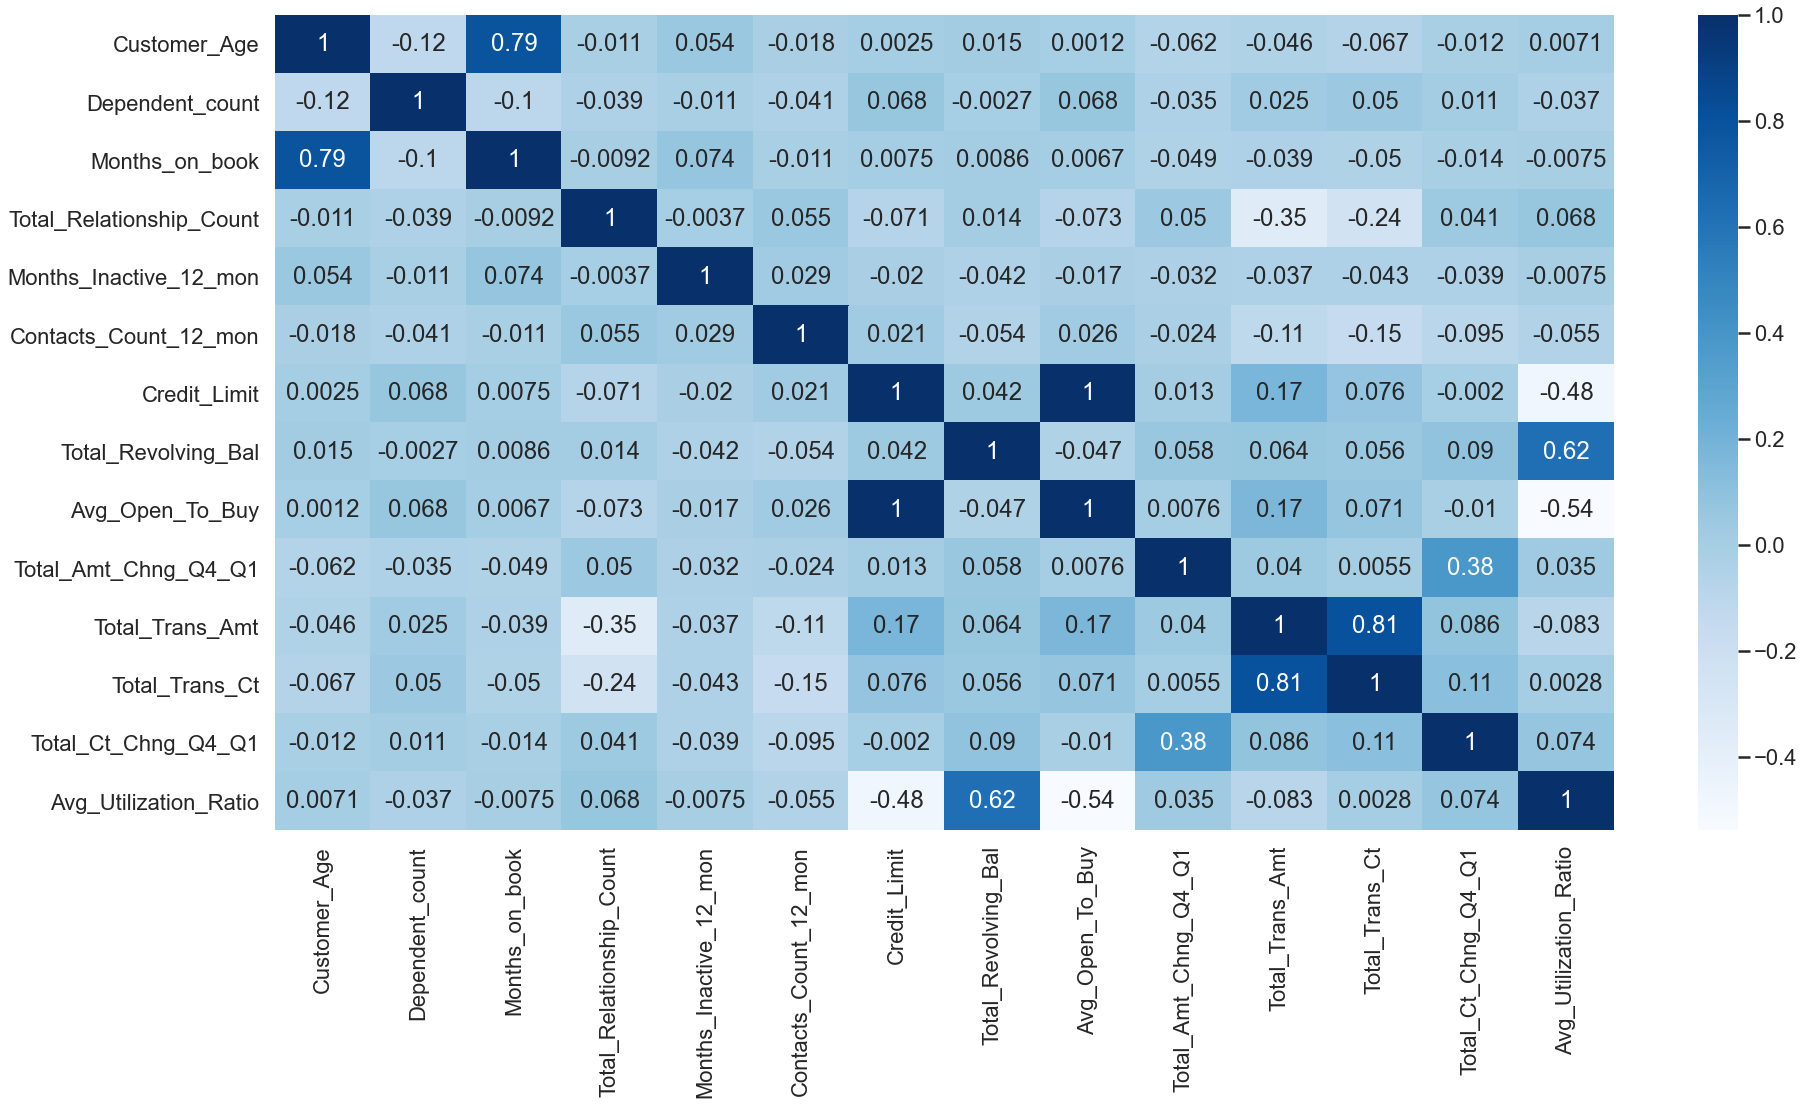

In [7]:
sns.set(rc={'figure.figsize':(30,15)})
sns.set_context("poster", font_scale=1)
    
sns.heatmap(df.iloc[:,1:].corr(), cmap='Blues', annot=True);

<AxesSubplot:xlabel='Contacts_Count_12_mon'>

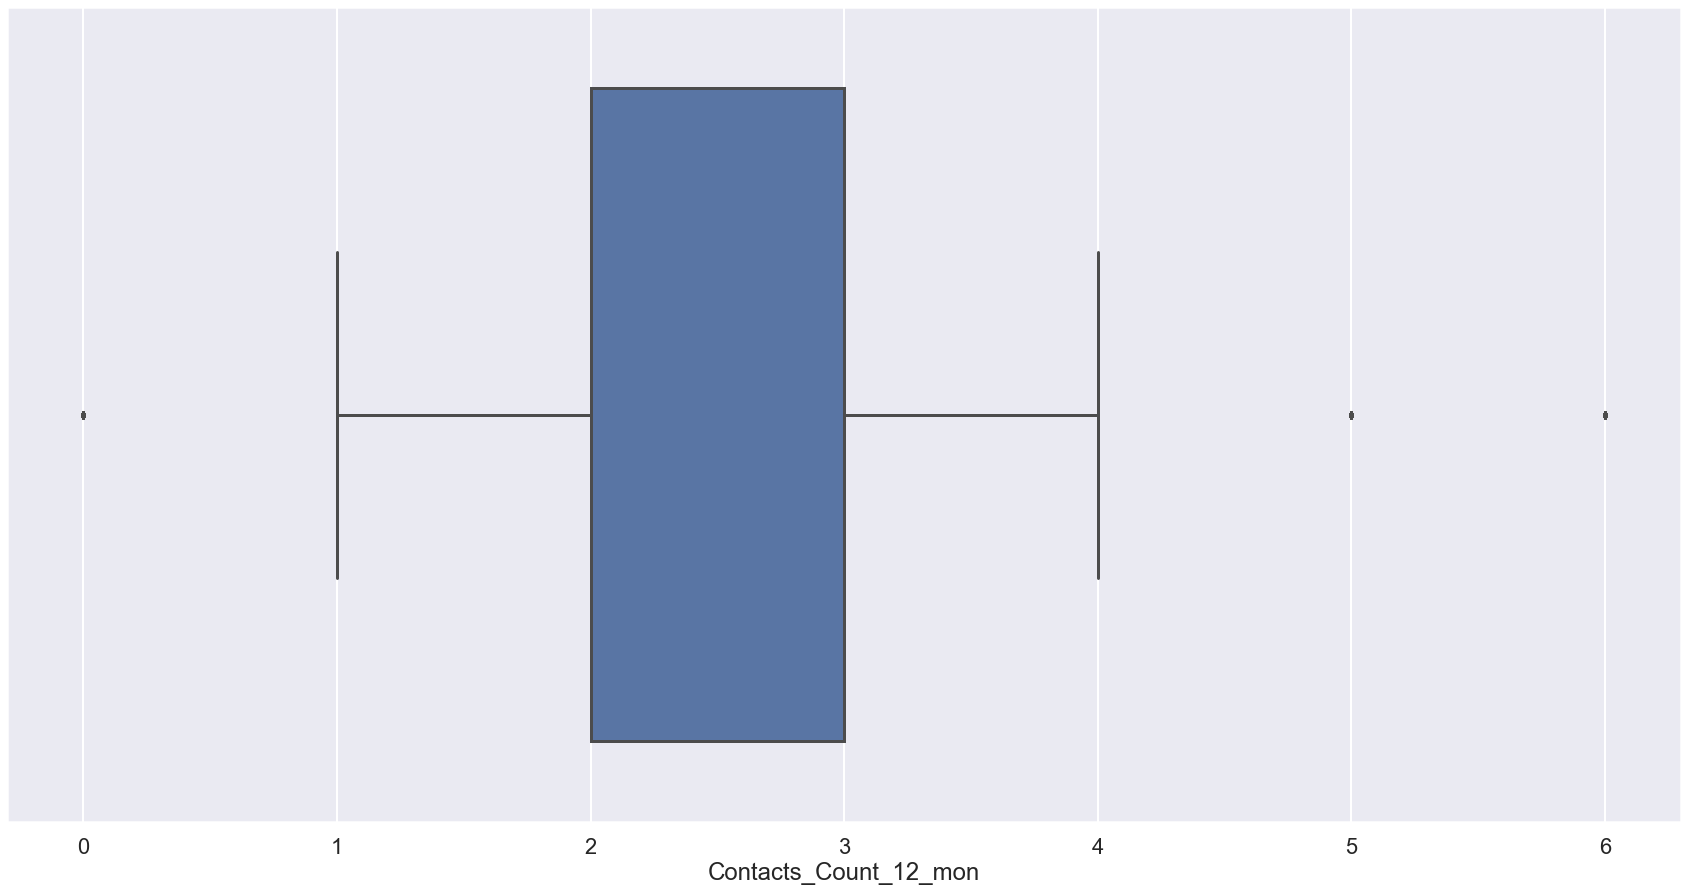

In [8]:
sns.boxplot(x=df['Contacts_Count_12_mon'])

In [9]:
df.Attrition_Flag.value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

Для теста и оценки качества модели возьмем 25% клиентов

In [10]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=55)

In [11]:
y = df_train.Attrition_Flag.apply(lambda x: 0 if x == 'Existing Customer' else 1)
X = df_train.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)
y_test = df_test.Attrition_Flag.apply(lambda x: 0 if x == 'Existing Customer' else 1)
X_test = df_test.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)

In [12]:
# Выделим категориальные фичи
cat_features = list(X.select_dtypes(exclude=[np.int64, np.float64]).columns)

In [13]:
cat_features

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [14]:
# Значения кат фичей в пределах 8, можно кодировать с помощью One-hot (для XGBoost)
for feature in cat_features:
    print(f'{feature}\n{df[feature].value_counts()}')

Gender
F    5358
M    4769
Name: Gender, dtype: int64
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


In [15]:
models_out = []

# CatBoost

CatBoost умеет работать с категориальными фичами, поэтому возьмем их без предобработки

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=55)

In [17]:
y_train.value_counts()

0    5098
1     978
Name: Attrition_Flag, dtype: int64

In [18]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [19]:
model = CatBoostClassifier(eval_metric='Precision', verbose=0)

In [20]:
params = {"iterations": [1000],
          "depth": [4, 6, 8],
          "l2_leaf_reg": [1, 3],
          "one_hot_max_size": [2, 5],
          "bagging_temperature": [0, 1]}

In [21]:
model.grid_search(params, X=train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9878787879
bestIteration = 287

0:	loss: 0.9878788	best: 0.9878788 (0)	total: 52.1s	remaining: 19m 58s

bestTest = 0.9693251534
bestIteration = 230

1:	loss: 0.9693252	best: 0.9878788 (0)	total: 1m 46s	remaining: 19m 28s

bestTest = 0.9764705882
bestIteration = 348

2:	loss: 0.9764706	best: 0.9878788 (0)	total: 2m 39s	remaining: 18m 33s

bestTest = 0.9704142012
bestIteration = 291

3:	loss: 0.9704142	best: 0.9878788 (0)	total: 3m 30s	remaining: 17m 30s

bestTest = 0.9771428571
bestIteration = 227

4:	loss: 0.9771429	best: 0.9878788 (0)	total: 4m 47s	remaining: 18m 11s

bestTest = 0.9813664596
bestIteration = 141

5:	loss: 0.9813665	best: 0.9878788 (0)	total: 6m 18s	remaining: 18m 54s

bestTest = 0.976744186
bestIteration = 221

6:	loss: 0.9767442	best: 0.9878788 (0)	total: 7m 33s	remaining: 18m 20s

bestTest = 0.9824561404
bestIteration = 198

7:	loss: 0.9824561	best: 0.9878788 (0)	total: 8m 48s	remaining: 17m 37s

bestTest = 0.9763313609
bestIteration = 175

8:	loss: 0.9

{'params': {'bagging_temperature': 0,
  'depth': 4,
  'one_hot_max_size': 2,
  'l2_leaf_reg': 1,
  'iterations': 1000},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
       

In [22]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Total_Trans_Ct,33.293623
1,Total_Trans_Amt,28.301874
2,Credit_Limit,6.471229
3,Total_Amt_Chng_Q4_Q1,6.039584
4,Total_Revolving_Bal,5.331772
5,Total_Ct_Chng_Q4_Q1,4.533091
6,Total_Relationship_Count,3.758499
7,Months_Inactive_12_mon,2.691132
8,Customer_Age,2.622205
9,Contacts_Count_12_mon,1.971208


In [23]:
y_pred = model.predict(X_test)

In [24]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9333333333333332, ROC_AUC: 0.9488418517697012, pres: 0.9642857142857143'

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.96      0.90      0.93       418

    accuracy                           0.98      2532
   macro avg       0.97      0.95      0.96      2532
weighted avg       0.98      0.98      0.98      2532



Обучим модель с подобранными параметрами на всей тренировочной выборке

In [26]:
best_params = model.get_params()

In [27]:
best_params

{'verbose': 0,
 'eval_metric': 'Precision',
 'bagging_temperature': 0,
 'depth': 4,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 1,
 'iterations': 1000}

In [28]:
best_cb_model = CatBoostClassifier(**best_params)

In [29]:
X_pool = Pool(X, y, cat_features=cat_features)
best_cb_model.fit(X_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
y_pred = best_cb_model.predict(X_test)

In [31]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9358024691358025, ROC_AUC: 0.950274542466944, pres: 0.9668367346938775'

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.97      0.91      0.94       418

    accuracy                           0.98      2532
   macro avg       0.97      0.95      0.96      2532
weighted avg       0.98      0.98      0.98      2532



In [33]:
models_out.append((f'CatBoost_eval_precision_bagging_temp_0_depth_4_one_hote_max_size_2_l2_leaf_reg_1_iter_100', f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred)))

Кредитный лимит и Avg_Open_To_Buy (сумма покупок?) коррелируют (больше лимита не купишь), но можно попробовать новую фичу:
использован ли весь лимит

In [34]:
df['is_sum_enough'] = df['Credit_Limit'] - df['Avg_Open_To_Buy']
df['is_sum_enough'] = df['is_sum_enough'].apply(lambda x: 0 if x > 0 else 1)

In [35]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=55)

In [36]:
y = df_train.Attrition_Flag.apply(lambda x: 0 if x == 'Existing Customer' else 1)
X = df_train.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)
y_test = df_test.Attrition_Flag.apply(lambda x: 0 if x == 'Existing Customer' else 1)
X_test = df_test.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)

In [37]:
best_cb_model = CatBoostClassifier(**best_params)

In [38]:
X_pool = Pool(X, y, cat_features=cat_features)
best_cb_model.fit(X_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
y_pred = best_cb_model.predict(X_test)

In [40]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9369592088998765, ROC_AUC: 0.9505110609153831, pres: 0.969309462915601'

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.97      0.91      0.94       418

    accuracy                           0.98      2532
   macro avg       0.98      0.95      0.96      2532
weighted avg       0.98      0.98      0.98      2532



In [42]:
models_out.append((f'CatBoost_eval_precision_bagging_temp_0_depth_4_one_hote_max_size_2_l2_leaf_reg_1_iter_100_is_sum_enugh', f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred)))

In [43]:
best_cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Total_Trans_Ct,32.905111
1,Total_Trans_Amt,29.912827
2,Total_Amt_Chng_Q4_Q1,6.105522
3,Credit_Limit,6.006635
4,Total_Revolving_Bal,4.879260
5,Total_Ct_Chng_Q4_Q1,4.534089
6,Total_Relationship_Count,4.102656
7,Customer_Age,2.723822
8,Months_Inactive_12_mon,2.631908
9,Contacts_Count_12_mon,1.656400


In [44]:
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

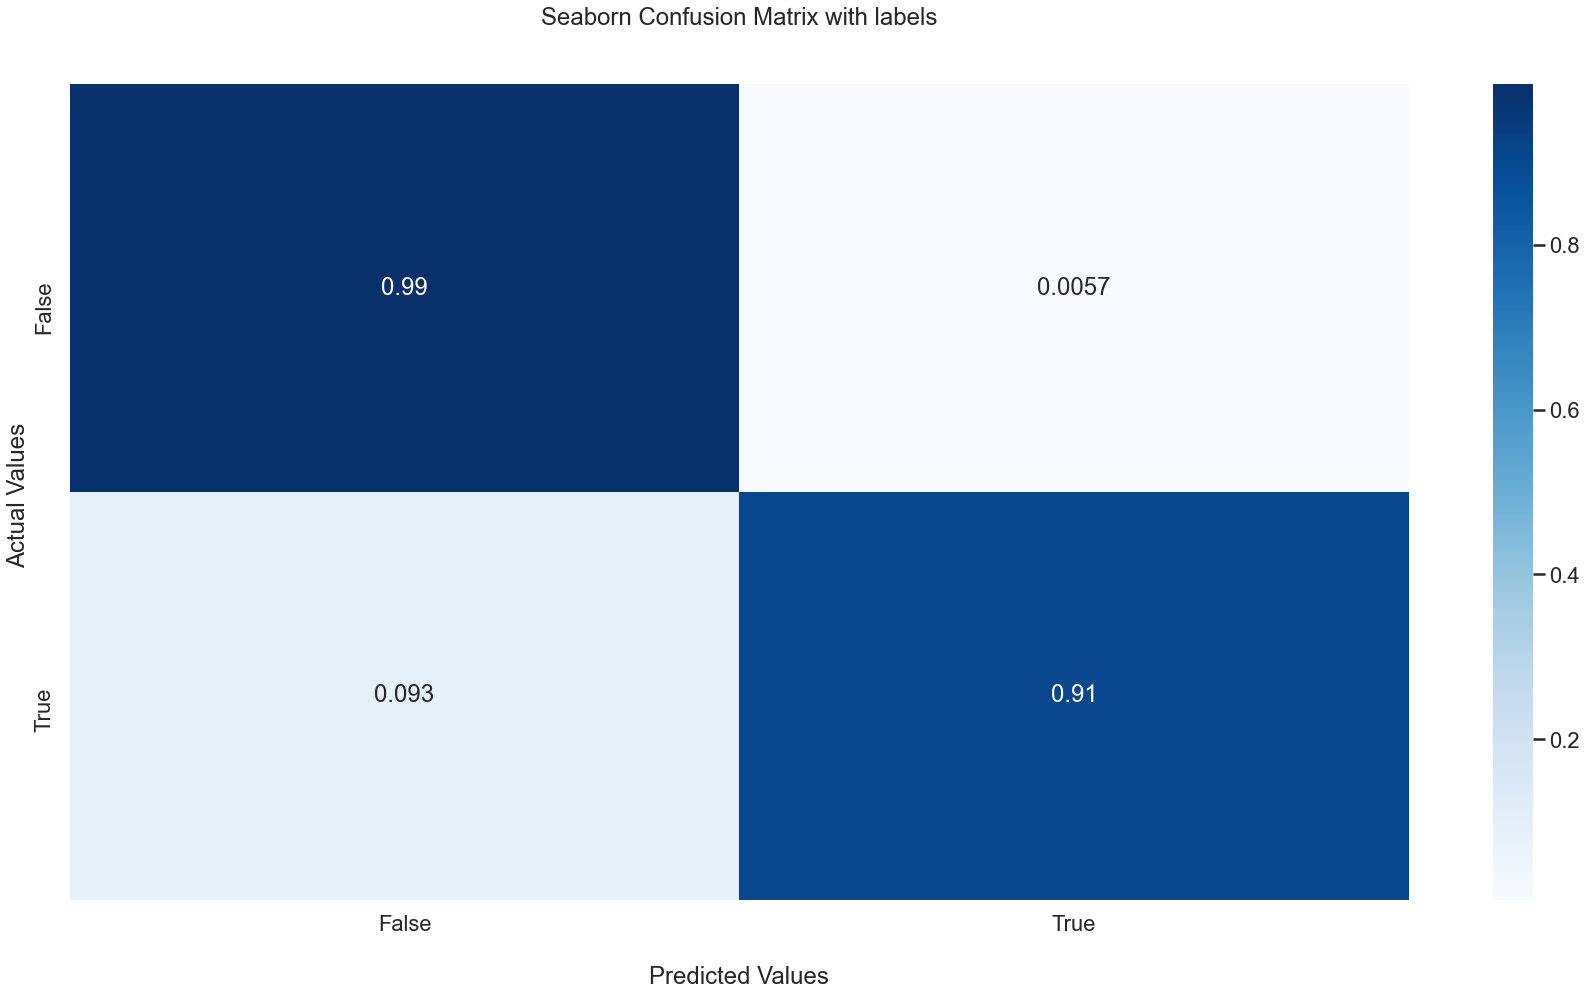

In [45]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])



# XGBoost

### Подготавливаем категориальные фичи

In [46]:
# ['Gender',
#  'Education_Level',
#  'Marital_Status',
#  'Income_Category',
#  'Card_Category']


In [47]:
df.Income_Category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

Закодируем доход в виде числовой фичи, чтобы не создавать 6 новых коррелирующих фичей

In [48]:
income_dict = {
    'Less than $40K': 20,
    '$40K - $60K': 50,
    '$80K - $120K': 100,
    '$60K - $80K': 70,
    'Unknown': None,
    '$120K +': 130
}
X.Income_Category = X.Income_Category.apply(lambda x: income_dict[x])
X_test.Income_Category = X_test.Income_Category.apply(lambda x: income_dict[x])

In [49]:
# кодируем пол бинарной фичей
le = LabelEncoder()
X.Gender = le.fit_transform(X.Gender)
X_test.Gender = le.transform(X_test.Gender)

In [50]:
cat_features = ['Education_Level',
                'Marital_Status',
                'Card_Category']

In [51]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[cat_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cat_features]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X.drop(cat_features, axis=1)
num_X_valid = X_test.drop(cat_features, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_valid, OH_cols_test], axis=1)

In [52]:
OH_X_train.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,5,6,7,8,9,10,11,12,13,14
8795,41,0,3,20.0,31,2,2,2,4086.0,1974,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
414,47,1,3,50.0,36,3,2,2,16138.0,1249,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
862,26,0,1,50.0,20,6,3,3,1438.3,673,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6942,57,1,2,100.0,36,5,3,3,4316.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4845,41,0,2,20.0,29,4,2,3,2670.0,2079,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [53]:
trees = 1000
colsample_bytree = 0.5
max_depth = 4
learning_rate = 0.03

xgboost_model = xgboost.XGBClassifier(n_estimators=trees, n_jobs=-1, max_depth=max_depth,
                                      learning_rate=learning_rate, booster='gbtree', eval_metric='logloss',
                                      colsample_bytree=colsample_bytree, seed=55)
xgboost_model.fit(OH_X_train, y, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=55, reg_alpha=0, reg_lambda=1, ...)

In [54]:
y_pred = np.argmax(xgboost_model.predict_proba(OH_X_test), axis=1)

In [55]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9183168316831682, ROC_AUC: 0.9392860537858795, pres: 0.9512820512820512'

In [56]:
xgboost_model = xgboost.XGBClassifier(seed=55)

In [57]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [500, 1000, 2000],
           'colsample_bytree': [0.1, 0.5, 0.3, 0.7]}

In [58]:
clf = GridSearchCV(estimator=xgboost_model, param_grid=params, scoring='precision', verbose=1)

clf.fit(OH_X_train, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 17.0min finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [59]:
clf.best_params_

{'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500}

In [60]:
trees = 500
colsample_bytree = 0.7
max_depth = 3
learning_rate = 0.1

xgboost_model = xgboost.XGBClassifier(n_estimators=trees, n_jobs=-1, max_depth=max_depth,
                                      learning_rate=learning_rate, booster='gbtree', eval_metric='map',
                                      colsample_bytree=colsample_bytree, seed=55)
xgboost_model.fit(OH_X_train, y, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='map', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=55,
              reg_alpha=0, reg_lambda=1, ...)

In [61]:
y_pred = np.argmax(xgboost_model.predict_proba(OH_X_test), axis=1)

In [62]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9306930693069309, ROC_AUC: 0.9464495072720935, pres: 0.9641025641025641'

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.96      0.90      0.93       418

    accuracy                           0.98      2532
   macro avg       0.97      0.95      0.96      2532
weighted avg       0.98      0.98      0.98      2532



In [64]:
models_out.append((f'XGBoost_trees_500_colsample_by_tree_0.7_max_depth_3_lr_0.1', f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred)))

In [65]:
cf_matrix = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

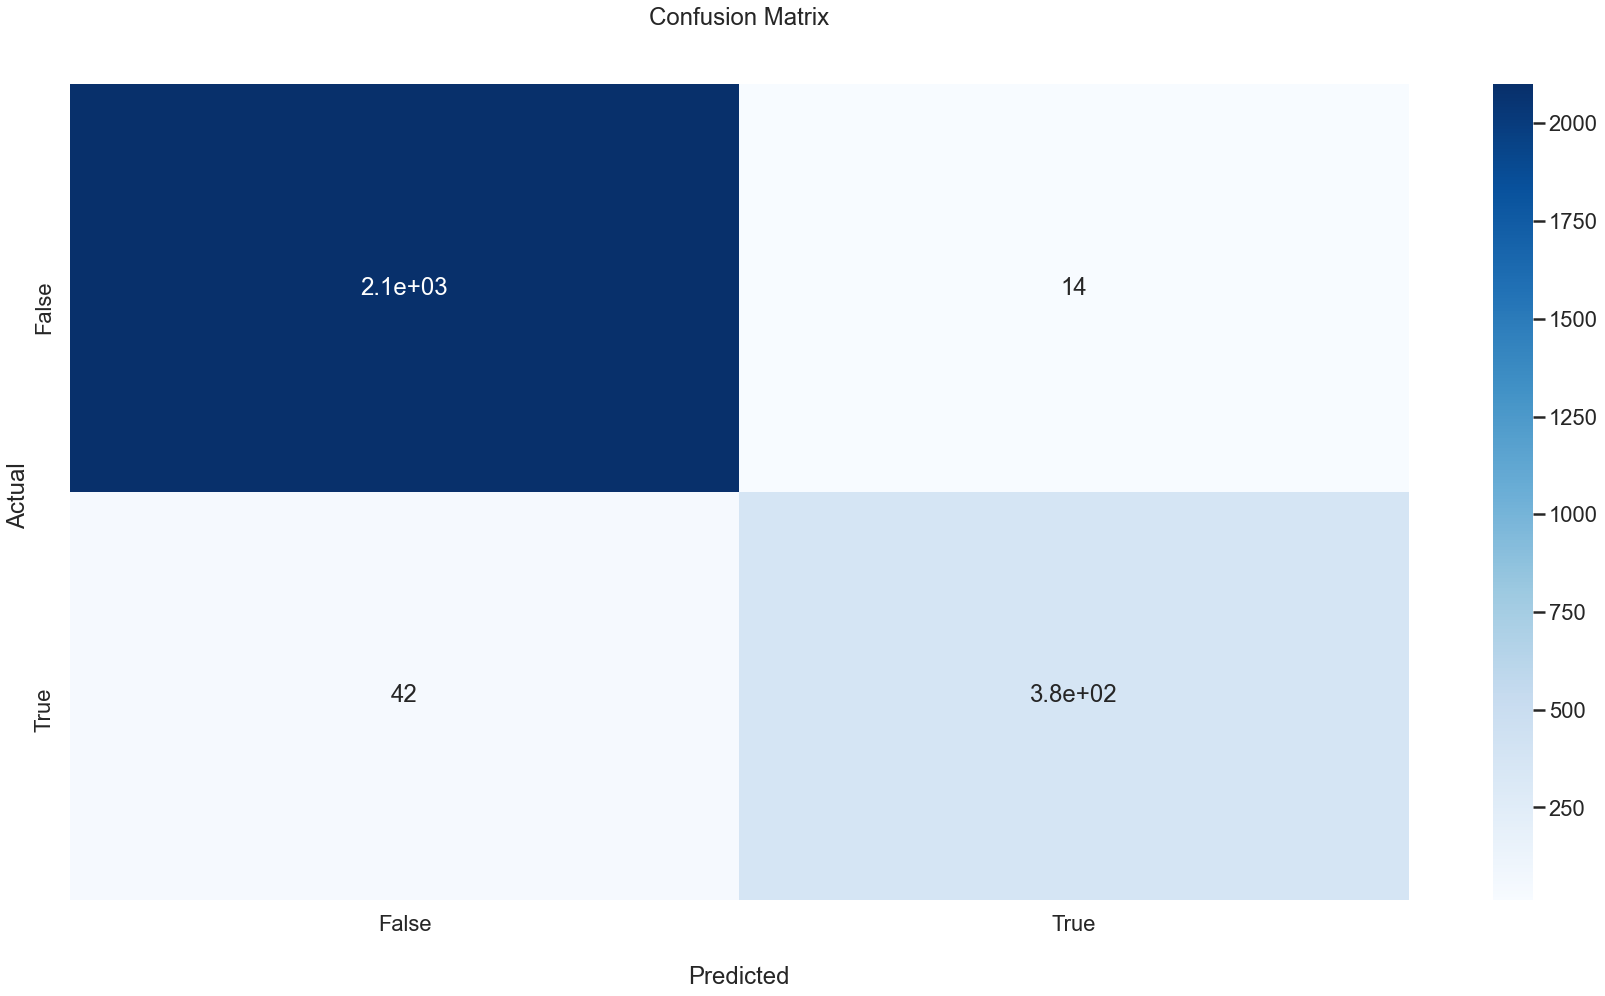

In [66]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [67]:
dict(zip(OH_X_train.columns, xgboost_model.feature_importances_))

{'Customer_Age': 0.0317282,
 'Gender': 0.04856516,
 'Dependent_count': 0.012546578,
 'Income_Category': 0.007062769,
 'Months_on_book': 0.019263294,
 'Total_Relationship_Count': 0.104825586,
 'Months_Inactive_12_mon': 0.050178982,
 'Contacts_Count_12_mon': 0.035483632,
 'Credit_Limit': 0.019034917,
 'Total_Revolving_Bal': 0.13993993,
 'Avg_Open_To_Buy': 0.018818086,
 'Total_Amt_Chng_Q4_Q1': 0.03631598,
 'Total_Trans_Amt': 0.068569206,
 'Total_Trans_Ct': 0.14942652,
 'Total_Ct_Chng_Q4_Q1': 0.05980205,
 'Avg_Utilization_Ratio': 0.089296296,
 'is_sum_enough': 0.0016591549,
 0: 0.010551154,
 1: 0.0,
 2: 0.0053476295,
 3: 0.006904745,
 4: 0.010140284,
 5: 0.007224187,
 6: 0.004622549,
 7: 0.0074458225,
 8: 0.020606996,
 9: 0.010408797,
 10: 0.008792084,
 11: 0.00915332,
 12: 0.0,
 13: 0.0,
 14: 0.0062860916}

## Попробуем удалить "шумы" из выборки

In [68]:
for col in num_X_train.columns:
    print(col, len(num_X_train[num_X_train[col].isna()]))

Customer_Age 0
Gender 0
Dependent_count 0
Income_Category 832
Months_on_book 0
Total_Relationship_Count 0
Months_Inactive_12_mon 0
Contacts_Count_12_mon 0
Credit_Limit 0
Total_Revolving_Bal 0
Avg_Open_To_Buy 0
Total_Amt_Chng_Q4_Q1 0
Total_Trans_Amt 0
Total_Trans_Ct 0
Total_Ct_Chng_Q4_Q1 0
Avg_Utilization_Ratio 0
is_sum_enough 0


In [69]:
num_X_train.fillna({'Income_Category': -1}, inplace=True)

In [70]:
# nu=0.99987
nu = 0.9998

clf = OneClassSVM(gamma='auto', nu=nu).fit(num_X_train)

In [71]:
outliers = clf.predict(num_X_train)

In [72]:
unique, counts = np.unique(outliers, return_counts=True)

In [73]:
dict(zip(unique, counts))

{-1: 338, 1: 7257}

In [74]:
OH_X_train['outlier'] = outliers
OH_X_train['y'] = y
OH_X_train_filter = OH_X_train[OH_X_train['outlier'] == 1]
y_filter = OH_X_train_filter['y']
OH_X_train_filter = OH_X_train_filter.drop(['y', 'outlier'], axis=1)

In [75]:
trees = 500
colsample_bytree = 0.7
max_depth = 3
learning_rate = 0.1

pos_weight = 8500/1627

xgboost_model = xgboost.XGBClassifier(n_estimators=trees, n_jobs=-1, max_depth=max_depth,
                                      learning_rate=learning_rate, booster='gbtree', eval_metric='logloss',
                                      colsample_bytree=colsample_bytree, scale_pos_weight=pos_weight, seed=55)
xgboost_model.fit(OH_X_train_filter, y_filter, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=55, reg_alpha=0, reg_lambda=1, ...)

In [76]:
y_pred = xgboost_model.predict(OH_X_test)

In [77]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}, pres: {precision_score(y_test, y_pred)}'

'F1: 0.9208972845336482, ROC_AUC: 0.9572829575443725, pres: 0.9090909090909091'

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2114
           1       0.91      0.93      0.92       418

    accuracy                           0.97      2532
   macro avg       0.95      0.96      0.95      2532
weighted avg       0.97      0.97      0.97      2532



In [79]:
models_out.append((f'XGBoost_trees_500_colsample_by_tree_0.7_max_depth_3_lr_0.1_outlier_nu_0.9998', f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred)))

### Подбор оптимального порога для принятия решения моделью

In [80]:
def investigate_model(model, X, y, cv, X_test, y_test):
    """
    оценить стратегию подбора порога
    """
    df = pd.DataFrame(index=['train', 'test0', 'cv', 'test', 'theta'])
    # ф-ии качества бинаризации
    scores = [f1_score, precision_score]
    # на cv
    a_cv = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:,1]
    model.fit(X, y)
    # на обучении
    a_train = model.predict_proba(X)[:,1]
    b_train = model.predict(X)
    # на тесте
    a_test = model.predict_proba(X_test)[:,1]
    b_test = model.predict(X_test)
    
    # оптимальный порог по cv
    thetas = np.linspace(0, 1, 101)
    for s in scores:
        q = np.array([s(y, a_cv > t) for t in thetas])
        i = np.argmax(q)
        t = thetas[i]
        s_cv = q[i]
        s_test = s(y_test, a_test > t)
        sb_train = s(y, b_train)
        sb_test = s(y_test, b_test)
        print (s.__name__, sb_train, sb_test, s_cv, s_test, t)
        df[s.__name__] = [sb_train, sb_test, s_cv, s_test, t]
        
        print (s.__name__, sb_train, sb_test, s_cv)
        df[s.__name__] = [sb_train, sb_test, s_cv, sb_test, np.NaN]
    return (df)

In [81]:
treshold = investigate_model(xgboost_model, OH_X_train, y, 10, OH_X_test, y_test)

ValueError: Feature shape mismatch, expected: 34, got 32

In [ ]:
y_pred = xgboost_model.predict_proba(OH_X_test)[:,1] > 0.44

In [ ]:
f'F1: {f1_score(y_test, y_pred)}, ROC_AUC: {roc_auc_score(y_test, y_pred)}'

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


In [ ]:
cf_matrix

# Итоговые Модели:

In [ ]:
models_out_dict = {x[0]: x[1:] for x in models_out}
models_out_dict

In [ ]:
df_models = pd.DataFrame(models_out_dict.values(), columns=['f1', 'roc-auc', 'precision'], index=models_out_dict.keys())

In [ ]:
df_models

In [ ]:
plt.figure(figsize=(19,13))
sns.heatmap(df_models, annot=True, annot_kws={"fontsize":25})

С минимальными изменениями вхлдных данных хорошо себя показала модель CatBoost с настроенными параметрами, 
немного докидывает добавление фичи, связывающей кредитный лимит и покупки по карте (с эти можно работать еще). Удаление шумов 
не дает сильного прироста из-за того что выборка достаточно чистая. Итоговую модель и порог следует выбирать в соответствии 
с бизнес метриками. В приоритете скорее precision, из-за того, что звонок клиенту, который не собирается уходить 
может спровоцировать уход. 